In [78]:
import sys
 
sys.path.append('/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/lcls_tools') # path to tools 
 
import common.data_analysis.archiver as arch # type: ignore
from datetime import datetime
from datetime import timedelta
import time
import matplotlib.pyplot as plt
import numpy as np
from sympy import * 

Goal: time a request

In [79]:
# specify a start date
start_date = "2024/02/10 16:48:18"
end_date = "2024/03/10 16:48:18" 
format_string = "%Y/%m/%d %H:%M:%S"
start_date_obj = datetime.strptime(start_date, format_string)
end_date_obj = datetime.strptime(end_date, format_string)

In [80]:
# submit request with a list of PVs
start = time.time()
data = arch.get_values_over_time_range(["BPMS:L0B:0183:FW:X_SLOW"], start_date_obj, end_date_obj)
end = time.time()
print(f"Total time: {(end - start):.2f} s")

Total time: 2.21 s


Goal: time a series of increasingly bigger requests and predict how long it would take to request a year of full data

In [81]:
# test: 
# - 1 day
# - 2 days
# - 3 days
# - ... and so on for 1 month
# then extrapolate to predict for 1 year. Repeat this experiment for a variety of PVs

def plot_and_return_year_timing(pv_str : str): 
    y = []
    x = []
    for i in range(2, 9): 
        # set date interval
        start_str = "2024/04/01 00:00:00"
        end_str = f"2024/04/0{i} 00:00:00" 
        # format for the request function
        formatter = "%Y/%m/%d %H:%M:%S"
        start_obj = datetime.strptime(start_str, formatter)
        end_obj = datetime.strptime(end_str, formatter)
        # time the request
        start_timer = time.time()
        arch.get_values_over_time_range([pv_str, pv_str], start_obj, end_obj)
        end_timer = time.time()
        # add the data point so it can be graphed
        data_point = round((end_timer - start_timer), 4)
        y.append(data_point)
        x.append(i - 1)  # length of the interval in the request
    plt.scatter(x, y)
    m, b = np.polyfit(x, y, deg=1)
    year_request_time = float(m * 365 + b)  # time it takes to request a year of data for the PV
    plt.axline(xy1=(0, b), slope=m, label=f"y = {m:.3f}x + {b:.3f}")
    plt.xlim(0, 365)
    plt.ylim(0, year_request_time + 5)  # view the whole projection
    plt.xlabel("Days per request")
    plt.ylabel("Time (s)")
    return round(year_request_time, 3)

228.959

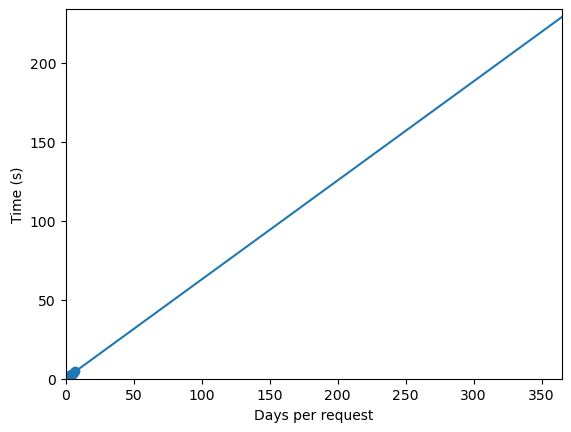

In [82]:
plot_and_return_year_timing("BPMS:L0B:0183:FW:X_SLOW")

225.385

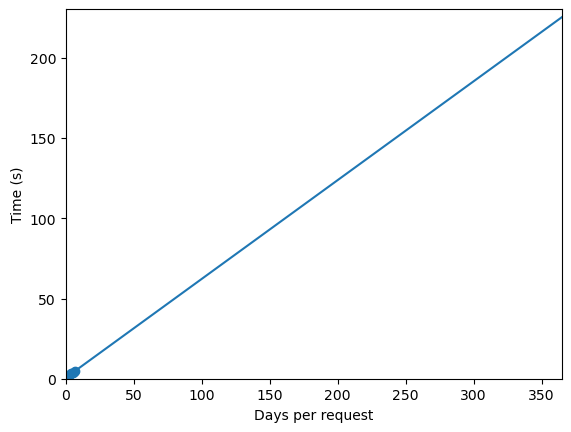

In [83]:
plot_and_return_year_timing("SOLN:GUNB:100:BACT")

While running this experiment, I discovered that there is another, even more limiting constraint. It is the amount of data that can be requested from the server. 

This occurs a lot earlier, and it results in a: 

`
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
--ServerApp.iopub_data_rate_limit.
`

This is unfortunate, as most users of this tool, like me, are probably going to use it in Jupyter Notebook, and I don't want to have users have to set config variables just to use my tool reliably. 

Goal: print out the amount of days, number of data points collected until the data rate is exceeded

In [88]:
def print_days_data_until_exceeded(pv_str : str): 
    for i in range(2, 30): 
        # set date interval
        start_str = "2024/04/01 00:00:00"
        if i < 10: 
            end_str = f"2024/04/0{i} 00:00:00"
        else: 
            end_str = f"2024/04/{i} 00:00:00"
        # format for the request function
        formatter = "%Y/%m/%d %H:%M:%S"
        start_obj = datetime.strptime(start_str, formatter)
        end_obj = datetime.strptime(end_str, formatter)
        # time the request
        start_timer = time.time()
        arch_data = arch.get_values_over_time_range([pv_str, pv_str], start_obj, end_obj)
        end_timer = time.time()
        # add the data point so it can be graphed
        time_request = round((end_timer - start_timer), 4)
        num_days = i - 1
        num_data_points = len(arch_data[pv_str].values)  # number of requested values
        print(f"Days: {num_days} | Points: {num_data_points} | Time: {time_request:.2f} s")

print_days_data_until_exceeded("BPMS:L0B:0183:FW:X_SLOW")

Days: 1 | Points: 114086 | Time: 0.80 s
Days: 2 | Points: 232020 | Time: 1.57 s
Days: 3 | Points: 350478 | Time: 1.96 s
Days: 4 | Points: 489878 | Time: 2.74 s
Days: 5 | Points: 635880 | Time: 3.08 s
Days: 6 | Points: 772930 | Time: 3.84 s
Days: 7 | Points: 916222 | Time: 4.10 s
Days: 8 | Points: 1015528 | Time: 4.92 s
Days: 9 | Points: 1049548 | Time: 5.08 s
Days: 10 | Points: 1049548 | Time: 5.02 s
Days: 11 | Points: 1081632 | Time: 6.46 s
Days: 12 | Points: 1235324 | Time: 8.81 s
Days: 13 | Points: 1378708 | Time: 7.13 s
Days: 14 | Points: 1520222 | Time: 6.98 s
Days: 15 | Points: 1656122 | Time: 7.26 s
Days: 16 | Points: 1805044 | Time: 7.78 s
Days: 17 | Points: 1944906 | Time: 8.90 s
Days: 18 | Points: 2062934 | Time: 9.23 s
Days: 19 | Points: 2151394 | Time: 10.54 s
Days: 20 | Points: 2282052 | Time: 10.34 s
Days: 21 | Points: 2430744 | Time: 11.35 s
Days: 22 | Points: 2530872 | Time: 10.72 s
Days: 23 | Points: 2548108 | Time: 11.90 s
Days: 24 | Points: 2548108 | Time: 11.16 s
Da

It didn't throw an error, but the amount of data stopped increasing after day 26. All PVs have similar amount of data rates, but it's not consistent. One approach would be to see if it scales linearly, so that we could make a projection for every PV. 

Goal: get an estimate for how many days it will take to hit the hard cap. This is to test how accurate a prediction like this can be, compared to the previous data collection. 

In [87]:
def predict_days_data_until_exceeded(pv_str : str): 
    x = []
    y = []
    for i in range(2, 9): 
        # set date interval
        start_str = "2024/04/01 00:00:00"
        end_str = f"2024/04/0{i} 00:00:00"
        # format for the request function
        formatter = "%Y/%m/%d %H:%M:%S"
        start_obj = datetime.strptime(start_str, formatter)
        end_obj = datetime.strptime(end_str, formatter)
        # time the request
        start_timer = time.time()
        arch_data = arch.get_values_over_time_range([pv_str, pv_str], start_obj, end_obj)
        end_timer = time.time()
        # add the data point so it can be graphed
        time_request = round((end_timer - start_timer), 4)
        num_days = i - 1
        num_data_points = len(arch_data[pv_str].values)  # number of requested values
        print(f"Days: {num_days} | Points: {num_data_points} | Time: {time_request:.2f} s")
        # cache points for the estimate
        x.append(num_days)
        y.append(num_data_points)
    # want to know how many days it will take to hit the hard cap: when will y = 2.5E6? 
    m, b = np.polyfit(x, y, deg=1)
    days_to_exceeded = round(((2.5E6 - b) / m), 3)
    print(f"Days until cap exceeded: {days_to_exceeded}")

predict_days_data_until_exceeded("BPMS:L0B:0183:FW:X_SLOW")
# predict_days_data_until_exceeded("TORO:GUNB:360:CHRG")
# predict_days_data_until_exceeded("XCOR:GUNB:293:BACT")

Days: 1 | Points: 114086 | Time: 0.68 s
Days: 2 | Points: 232020 | Time: 1.31 s
Days: 3 | Points: 350478 | Time: 2.23 s
Days: 4 | Points: 489878 | Time: 2.74 s
Days: 5 | Points: 635880 | Time: 2.99 s
Days: 6 | Points: 772930 | Time: 4.68 s
Days: 7 | Points: 916222 | Time: 4.14 s
Days until cap exceeded: 18.828


Okay the prediction is somewhat accurate, and it gives an underestimate, which is good. I'll also limit the amount of requests to 2 million, so that should do the trick. 

Now I need to implement this in a function that makes an interval-based request using this calculation. 